In [1]:
# 必要なライブラリのインポート
import os
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

# 日本語フォント設定
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

try:
    if os.name == 'posix':
        japanese_fonts = ['Hiragino Sans', 'Hiragino Kaku Gothic Pro', 'Yu Gothic', 'Meiryo']
        for font in japanese_fonts:
            try:
                plt.rcParams['font.family'] = font
                break
            except:
                continue
except:
    pass

plt.rcParams['figure.figsize'] = (10, 6)
print("ライブラリのインポートが完了しました")

ライブラリのインポートが完了しました


In [2]:
def parse_directory_name(dir_name):
    params = dir_name.split(',')
    if len(params) < 30: return None, None, None
    try:
        cpnum = next((int(params[i]) for i in range(10) if int(params[i]) != 0), None)
        cpnum_range = next((int(params[i]) for i in range(10, 20) if int(params[i]) != 0), None)
        cpnum_dir = next((int(params[i]) for i in range(20, 30) if int(params[i]) != 0), None)
        return cpnum, cpnum_range, cpnum_dir
    except (ValueError, IndexError): return None, None, None

def collect_data_task1(logs_root='../../Logs/'):
    data_records = []
    logs_path = Path(logs_root)
    for tree_dir in logs_path.glob('tree=*'):
        tree_value = int(tree_dir.name.split('=')[1])
        for param_dir in tree_dir.iterdir():
            if not param_dir.is_dir(): continue
            cpnum, cpnum_range, cpnum_dir = parse_directory_name(param_dir.name)
            if cpnum is None: continue
            bug_path = param_dir / 'detected_bugs.csv'
            if not bug_path.exists(): continue
            with open(bug_path, 'r') as f:
                bug_results = [row[0] for row in csv.reader(f)]
                if len(bug_results) >= 5:
                    bug_detected_any = 1 if any(r not in ['timeout', 'null'] for r in bug_results[:5]) else 0
                    data_records.append({
                        'tree': tree_value, 'cpNum': cpnum, 
                        'cpNum_range': cpnum_range, 'cpNum_dir': cpnum_dir,
                        'bug_detected_any': bug_detected_any
                    })
    df = pd.DataFrame(data_records)
    print(f"データ収集完了: {len(df)}件のレコード")
    return df

df_agg = collect_data_task1()

データ収集完了: 2160件のレコード


# タスク1: 5回実行して1回でもバグ発見の予測（GridSearchCVによる最適化）

In [3]:
X = df_agg[['tree', 'cpNum', 'cpNum_range', 'cpNum_dir']]
y = df_agg['bug_detected_any']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
print(f"訓練データ: {len(X_train)}, テストデータ: {len(X_test)}")

訓練データ: 1728, テストデータ: 432


## GridSearchCVによる探索

In [4]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(random_state=42, max_iter=1000, solver='liblinear'))
])

param_grid = {
    'lr__C': np.logspace(-3, 3, 7),
    'lr__penalty': ['l1', 'l2'],
    'lr__class_weight': [None, 'balanced']
}

grid_search = GridSearchCV(
    pipeline, 
    param_grid, 
    cv=cv, 
    scoring='f1', 
    n_jobs=-1, 
    verbose=1
)

print("探索を開始します...")
grid_search.fit(X_train, y_train)

print(f"\nBest Parameters: {grid_search.best_params_}")
print(f"Best CV F1-Score: {grid_search.best_score_:.4f}")

探索を開始します...
Fitting 10 folds for each of 28 candidates, totalling 280 fits



Best Parameters: {'lr__C': np.float64(0.001), 'lr__class_weight': None, 'lr__penalty': 'l2'}
Best CV F1-Score: 0.9156


## 最良モデルの評価

In [5]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("【テストデータでの評価】")
print(f"Accuracy:  {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred):.4f}")

print("\n【混同行列】")
print(confusion_matrix(y_test, y_pred))

print("\n【モデル係数（全データ再学習後）】")
best_model.fit(X, y)
final_lr = best_model.named_steps['lr']
for name, coef in zip(X.columns, final_lr.coef_[0]):
    print(f"{name:<12}: {coef:.6f}")
print(f"{'intercept':<12}: {final_lr.intercept_[0]:.6f}")

【テストデータでの評価】
Accuracy:  0.8449
Precision: 0.8449
Recall:    1.0000
F1-Score:  0.9159

【混同行列】
[[  0  67]
 [  0 365]]

【モデル係数（全データ再学習後）】
tree        : 0.005698
cpNum       : 0.057594
cpNum_range : 0.198349
cpNum_dir   : 0.020275
intercept   : 0.488127


## パラメータ感度分析

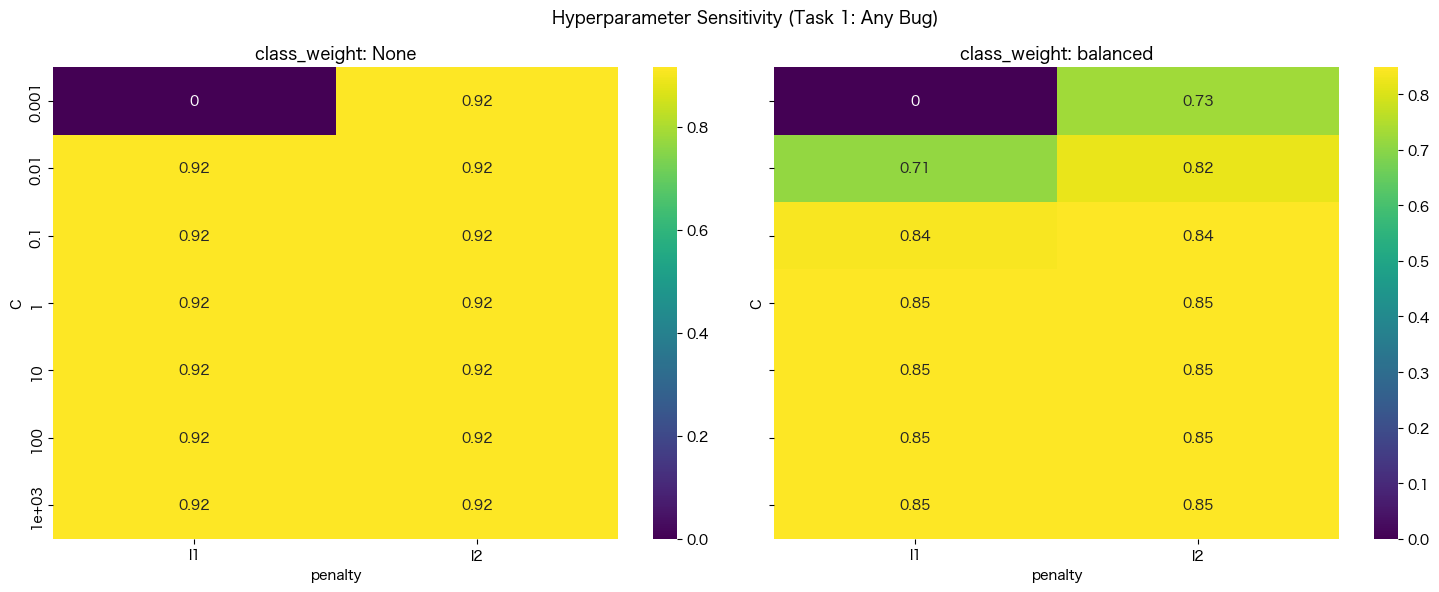

In [6]:
results_df = pd.DataFrame(grid_search.cv_results_)
results_df['param_lr__class_weight'] = results_df['param_lr__class_weight'].fillna('None')

weights = results_df['param_lr__class_weight'].unique()
fig, axes = plt.subplots(1, len(weights), figsize=(15, 6), sharey=True)

if len(weights) == 1: axes = [axes]

for i, weight in enumerate(weights):
    subset = results_df[results_df['param_lr__class_weight'] == weight]
    pvt = subset.pivot_table(index='param_lr__C', columns='param_lr__penalty', values='mean_test_score')
    pvt.index = [f'{x:.3g}' for x in pvt.index]
    sns.heatmap(pvt, annot=True, cmap='viridis', ax=axes[i])
    axes[i].set_title(f'class_weight: {weight}')
    axes[i].set_ylabel('C')
    axes[i].set_xlabel('penalty')

plt.suptitle('Hyperparameter Sensitivity (Task 1: Any Bug)')
plt.tight_layout()
plt.show()